<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

**Мягкий дедлайн:** 23:59MSK 19.05.2024

**Жесткий дедлайн:** 23:59MSK 26.05.2024

In [3]:
# !pip install -r requirements.txt

In [1]:
import warnings
import gdown
import pandas as pd
import numpy as np
from copy import deepcopy

warnings.filterwarnings("ignore")

В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах. Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса.

В качестве инструмента воспользуемся библиотекой ETNA, документацию можно прочитать [тут](https://docs.etna.ai/stable/), и [чат](https://t.me/etna_support) комьюнити.

Мы будем использовать дневные данные реальных банкоматов для чего возьмем мультисегментный датасет.

In [2]:
url = 'https://gist.githubusercontent.com/Polzovat123/4d6d5e544e93429c2d3db29196e9c918/raw/24b27e60f587128d71678e267f51cd48472c6a84/atms_daily_cash.csv'
output = 'atms_daily_cash.csv'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

df = pd.read_csv('atms_daily_cash.csv', index_col=False)

Downloading...
From: https://gist.githubusercontent.com/Polzovat123/4d6d5e544e93429c2d3db29196e9c918/raw/24b27e60f587128d71678e267f51cd48472c6a84/atms_daily_cash.csv
To: /content/atms_daily_cash.csv
100%|██████████| 258k/258k [00:00<00:00, 4.98MB/s]


Полученные данные были просуммированы по банкоматам и дням эксплуатации, после чего залиты в gist, откуда мы и берем их.

Взглянем на то, что представляют из себя данные после этих действий:

In [3]:
df.head()

,datetime,atm_id,operation_value
0,2017-08-16,74,2.059266
1,2017-08-17,74,1.029633
2,2017-08-18,74,0.686422
3,2017-08-19,74,33.301267
4,2017-08-20,74,-12.237921


In [4]:
df[abs(df.operation_value) < 0.01]

,datetime,atm_id,operation_value
1273,2017-06-21,87,2.220446e-16


### Задание 1. EDA (1.75 балл)

Проведите разведывательный анализ данных с помощью `ETNA`- постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

Ссылку на туториал по EDA можно найти [тут](https://docs.etna.ai/stable/tutorials/103-EDA.html#EDA).

In [5]:
df.atm_id.unique()

array([ 74,  85,  86,  87,  88,  90,  91,  93,  94,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106])

In [4]:
from etna.datasets import TSDataset

In [5]:
ts = TSDataset(df.rename(columns={'datetime': 'timestamp', 'atm_id': 'segment', 'operation_value': 'target'}), freq="D")
ts.head(120)

segment,100,101,102,103,104,105,106,74,85,86,87,88,90,91,93,94,96,97,98,99
feature,target,target,target,target,target,target,target,target,target,target,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,,,
2017-06-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.617780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.441486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.235345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-13.532317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.398647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-10-02,130.557440,44.656646,420.796221,-77.281297,-30.182950,66.308353,34.948679,510.315439,212.722139,7.707537,379.022547,-284.149238,-114.465750,622.545416,62.484003,191.246940,155.239210,50.599098,-3.088898,-99.521366
2017-10-03,243.405196,12.502684,141.383294,-16.032854,19.268843,116.701525,131.086966,529.201847,197.836590,3.383079,70.162122,76.016320,137.706034,115.201202,205.897144,96.844320,-8.796006,49.863646,1997.144778,-0.941379


In [6]:
from etna.transforms import TimeSeriesImputerTransform

In [26]:
ts1 = TSDataset(df.rename(columns={'datetime': 'timestamp', 'atm_id': 'segment', 'operation_value': 'target'}), freq="D")
transforms = [TimeSeriesImputerTransform(in_column='target', strategy='constant', constant_value=0).fit(ts1)]
ts1.transform(transforms)

In [10]:
transforms

[TimeSeriesImputerTransform(in_column = 'target', strategy = 'constant', window = -1, seasonality = 1, default_value = None, constant_value = 0, )]

In [11]:
ts1.head(120)

segment,100,101,102,103,104,105,106,74,85,86,87,88,90,91,93,94,96,97,98,99
feature,target,target,target,target,target,target,target,target,target,target,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,,,
2017-06-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.617780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.441486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.235345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-13.532317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.398647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-10-02,130.557440,44.656646,420.796221,-77.281297,-30.182950,66.308353,34.948679,510.315439,212.722139,7.707537,379.022547,-284.149238,-114.465750,622.545416,62.484003,191.246940,155.239210,50.599098,-3.088898,-99.521366
2017-10-03,243.405196,12.502684,141.383294,-16.032854,19.268843,116.701525,131.086966,529.201847,197.836590,3.383079,70.162122,76.016320,137.706034,115.201202,205.897144,96.844320,-8.796006,49.863646,1997.144778,-0.941379


In [12]:
ts.isnull().sum() - ts1.isnull().sum()

segment  feature
100      target     3
101      target     3
102      target     3
103      target     3
104      target     3
105      target     3
106      target     3
74       target     3
85       target     3
86       target     3
87       target     3
88       target     3
90       target     3
91       target     3
93       target     3
94       target     3
96       target     3
97       target     3
98       target     3
99       target     3
dtype: int64

интересное наблюдение - это значит, что TimeSeriesImputerTransform, заполняющий пропуски внутри данных, для каждого сегмента заполнил по 3 значения ровно. Это можно исследовать во втором задании.

In [ ]:
ts1.plot()

In [ ]:
from etna.analysis import plot_periodogram
plot_periodogram(ts1, period=365.2425, amplitude_aggregation_mode="per-segment", xticks=[1, 2, 4, 6, 12, 26, 52, 104])

In [ ]:
from etna.analysis import stl_plot
stl_plot(ts=ts1, period=52)

In [ ]:
from etna.analysis import seasonal_plot
seasonal_plot(ts=ts1, cycle="quarter")

### Задание 2. Работа с пропущенными значениями и выбросами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

In [10]:
from etna.transforms import TimeSeriesImputerTransform

In [20]:
ts2 = TSDataset(df.rename(columns={'datetime': 'timestamp', 'atm_id': 'segment', 'operation_value': 'target'}), freq="D")
transforms = [TimeSeriesImputerTransform(in_column='target', strategy='constant', constant_value=0).fit(ts2)]
ts2.transform(transforms)

In [25]:
ts2.df.fillna(0, inplace=True)

In [ ]:
segments = self.segments
k = min(n_segments, len(segments))
columns_num = min(2, k)
rows_num = math.ceil(k / columns_num)
start = self.df.index.min() if start is None else pd.Timestamp(start)
end = self.df.index.max() if end is None else pd.Timestamp(end)

figsize = (figsize[0] * columns_num, figsize[1] * rows_num)
_, ax = plt.subplots(rows_num, columns_num, figsize=figsize, squeeze=False)
ax = ax.ravel()
rnd_state = np.random.RandomState(seed)
for i, segment in enumerate(sorted(rnd_state.choice(segments, size=k, replace=False))):
    df_slice = self[start:end, segment, column]  # type: ignore
    ax[i].plot(df_slice.index, df_slice.values)
    ax[i].set_title(segment)
    ax[i].grid()

In [ ]:
from etna.transforms import (
    LinearTrendTransform,
    DensityOutliersTransform,
    TimeSeriesImputerTransform,
)

transforms = [
    # удаляем выбросы из данных
    DensityOutliersTransform(
        in_column="target",
        window_size=45,
        n_neighbors=25,
        distance_coef=1.9
    ),
    # заполняем образовавшиеся пропуски
    TimeSeriesImputerTransform(
        in_column="target",
        strategy="running_mean"
    ),
    # вычитаем тренд
    LinearTrendTransform(in_column="target"),
]

Проверьте ряды на наличие выбросов, и очистите их соответствующим образом. Обоснуйте выбор.

In [ ]:
#YOUR CODE HERE#

### Задание 3. Построение Prophet (1.25 балла)

Постройте прогнозы с помощью Prophet и `etna.Pipeline`, под капотом `etna.Pipeline` обучит `ProphetModel` для каждого сегмента в отдельности. После этого оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [11]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest

In [12]:
HORIZON = 5

In [34]:
model = ProphetModel(daily_seasonality=True, yearly_seasonality=True)

# Создаем пайплайн с горизонтом предсказания 5 дней
pipeline = Pipeline(model=model, horizon=HORIZON)

# Оценка качества модели с помощью кросс-валидации
metrics = [SMAPE(), MAE()]

n_folds = 70  # количество фолдов для кросс-валидации

metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts1, metrics=metrics, n_folds=n_folds, n_jobs=2)

Streaming output truncated to the last 5000 lines.
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7wap27b7/fjchxne9.json
22:27:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7wap27b7/ovvku2p9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7wap27b7/bqyfnfoi.json
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4321', 'data', 'file=/tmp/tmp7wap27b7/fjchxne9.json', 'init=/tmp/tmp7wap27b7/ovvku2p9.json', 'output', 'file=/tmp/tmp7wap27b7/prophet_model025oe9tx/prophet_model-20240518222702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:27:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:27:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done p

In [36]:
fold_info_df

,train_start_time,train_end_time,test_start_time,test_end_time,fold_number
0,2017-06-09,2017-10-15,2017-10-16,2017-10-20,0
1,2017-06-09,2017-10-20,2017-10-21,2017-10-25,1
2,2017-06-09,2017-10-25,2017-10-26,2017-10-30,2
3,2017-06-09,2017-10-30,2017-10-31,2017-11-04,3
4,2017-06-09,2017-11-04,2017-11-05,2017-11-09,4
...,...,...,...,...,...
65,2017-06-09,2018-09-05,2018-09-06,2018-09-10,65
66,2017-06-09,2018-09-10,2018-09-11,2018-09-15,66
67,2017-06-09,2018-09-15,2018-09-16,2018-09-20,67
68,2017-06-09,2018-09-20,2018-09-21,2018-09-25,68


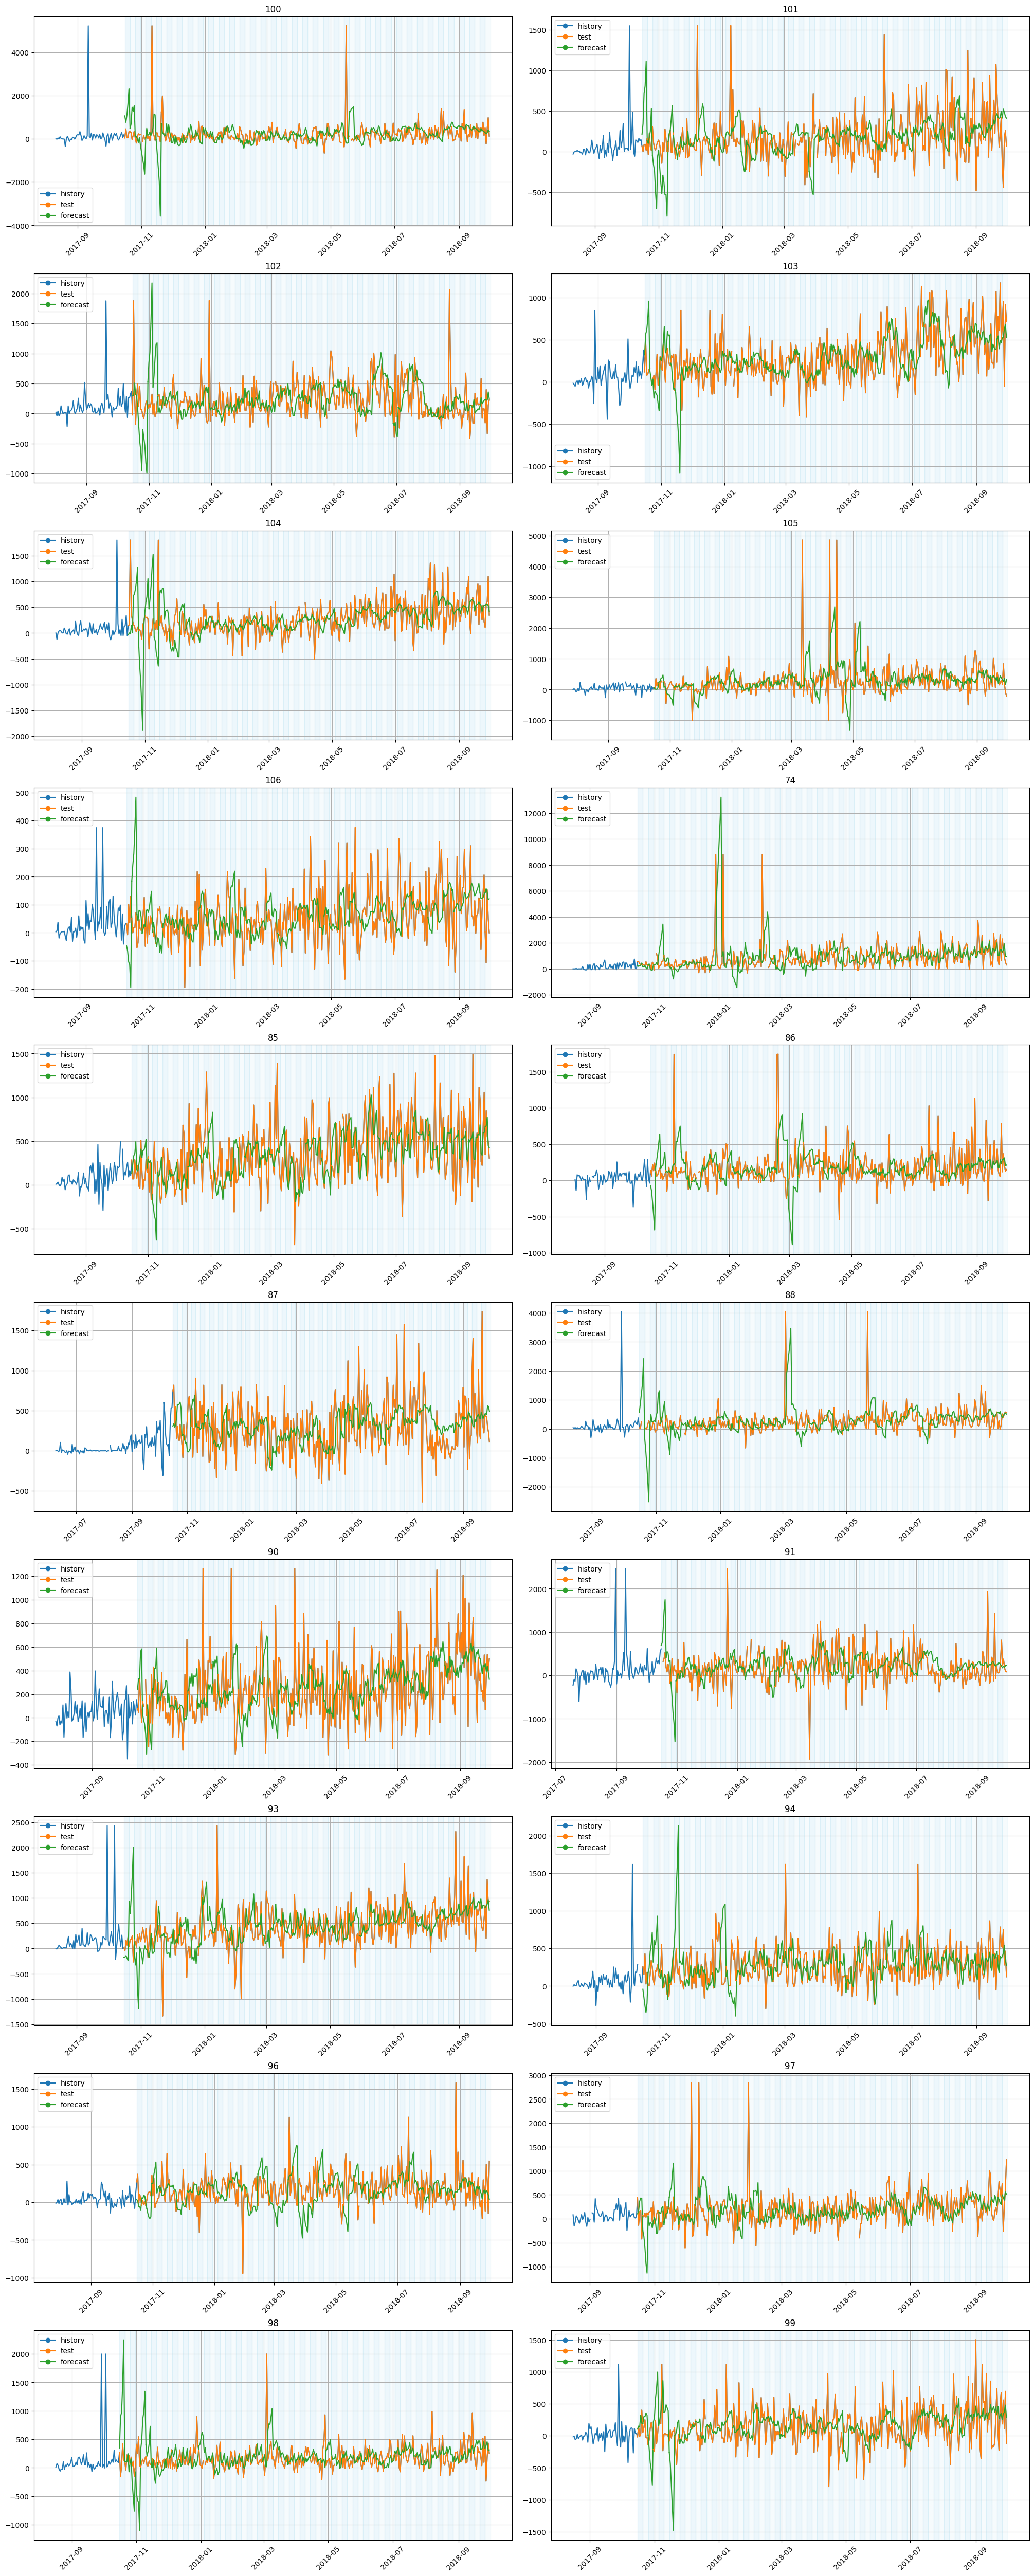

In [35]:
plot_backtest(forecast_df=forecast_df, ts=ts, history_len='all')

In [15]:
metrics_mean_segment = metrics_df.groupby('segment')[['SMAPE', 'MAE']].mean()
metrics_mean_segment.sort_values(by='SMAPE')

,SMAPE,MAE
segment,,
85,44.124840,221.068660
93,44.360659,248.477567
104,47.055497,229.835072
86,49.445262,127.911593
90,51.786705,157.745957
87,55.924469,252.851808
94,57.627476,199.289426
74,59.823840,682.114737
88,62.030090,176.199364


In [37]:
metrics_mean_segment = metrics_df.groupby('segment')[['SMAPE', 'MAE']].mean()
metrics_mean_segment.sort_values(by='SMAPE')
# вывод после обучения на 70 фолдах

,SMAPE,MAE
segment,,
93,85.607019,340.517841
103,86.931731,229.580228
85,87.529800,272.802464
74,88.036331,795.085313
94,88.903517,236.678758
104,97.492397,288.098822
90,98.201308,238.491277
98,100.961131,206.894211
87,101.037956,284.287048


Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

In [ ]:
#YOUR CODE HERE#

### Задание 4. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/etna-team/etna/blob/master/examples/303-hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [ ]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import TopDownReconciliator

In [ ]:
#YOUR CODE HERE#

Во второй части задания примените найденные на предыдущих этапах преобразования очистку от выбросов уже к иерархическому датасету, и запустите на нем Prophet с MAE на кросс-валидации.

In [ ]:
#YOUR CODE HERE#

### Задание 5. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества.

Из обязательного:
1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков
2) для катбуста включите в признаки результаты STL разложения. STL используем для убирания тренда за счет преобразования на месте.
* Кроме этого, подумайте на экспертном уровне,
    - Какие еще закономерности могут присутствовать и почему?
    - Что из этого кажется более предсказуемым, и почему?
    - Cделайте соответствующие признаки, и снабдите их кратким комментарием.

3) После этого, обучите на получившихся признаках модели. Для `CatBoost` рассмотрите 2 версии мультисегментную и на каждый ряд в отдельности.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [ ]:
from etna.analysis import acf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import (CatBoostMultiSegmentModel, CatBoostPerSegmentModel,
                         AutoARIMAModel)
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform

In [ ]:
from etna.analysis import plot_forecast
train_ts, test_ts = ts.train_test_split(
    train_start="2019-01-01",
    train_end="2019-10-31",
    test_start="2019-11-01",
    test_end="2019-11-30",
)

model = Pipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=transforms,
    horizon=HORIZON,
)

model.fit(train_ts)
forecast_ts = model.forecast()

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

### Задание 6. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [ ]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

In [ ]:
#YOUR CODE HERE#

### Задание 7. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [ ]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

In [ ]:
#YOUR CODE HERE#

### Задание 8*. Трансформер (бонус 2 балла)

Для желающих протестировать мощь трансформенных моделей предлагается "завести" модель из второго семинара по временным рядам на текущем датасете. На этот раз абсолютно все необходимые импорты и зависимости подгружаются на ваше усмотрение. Удалось ли вам улучшить качество по сравнению с классическими моделями / моделями на основе ML? Что бы вы предпочли внедрить в production?

*NB:* все, конечно, прекрасно знают механизм работы бонусных заданий, но порядка ряди прописать дисклеймер должны - итоговый балл за домашнее задание ставится по формуле min(10, ваш суммарный балл за задания).

In [ ]:
#YOUR CODE HERE#